# Detrended quantile mapping vs quantile delta mapping

This notebook is for comparing detrended quantile mapping (and some variants thereof) and quantile delta mapping. 

In [103]:
# config cell
import warnings
from pathlib import Path
import cftime
import dask
import numpy as np
import pandas as pd
import seaborn as sns
import xarray as xr
import matplotlib.pyplot as plt
from pyproj import Proj
from xclim import units, sdba, indices
from dask.distributed import Client

# for reloading the baeda module which is actively developing
import baeda
from importlib import reload

reload(baeda)

cutoff_time = cftime.DatetimeNoLeap(2015, 1, 1, 0, 0, 0, 0, 0)

# zarr_dir = Path("/beegfs/CMIP6/kmredilla/zarr_bias_adjust_inputs/zarr")
zarr_dir = Path("/center1/CMIP6/kmredilla/zarr_bias_adjust_inputs")

# era5_dir = Path("/beegfs/CMIP6/kmredilla/era5_3338_zarr/zarr")
era5_dir = Path("/center1/CMIP6/kmredilla/era5_zarr")

# models and scenarios to test
models = ["GFDL-ESM4"]
scenarios = ["ssp245"]
var_ids = ["tasmax", "pr"]

# dask.config.set({"large-graph-warning-threshold": "100MB"})

# this will be a dict for capturing all relevant results from each adjustment for later summarization
results = {}
for model in models + ["ERA5"]:
    results[model] = {}
    for var_id in var_ids:
        results[model][var_id] = {}

In [2]:
client = Client()

## Setup

### Connect ERA5 data

We will be re-using the ERA5 data throughout. Connect to the Zarr stores and create the relevant dataarrays we will need. 

In [3]:
era5_stores = {
    "t2max": era5_dir.joinpath("t2max_era5.zarr"),
    "pr": era5_dir.joinpath("pr_era5.zarr"),
}

era5_ds = baeda.open_era5_dataset(era5_stores)


### Test locations

We will perform an analysis on a handful of test locations across Alaska, seen here:

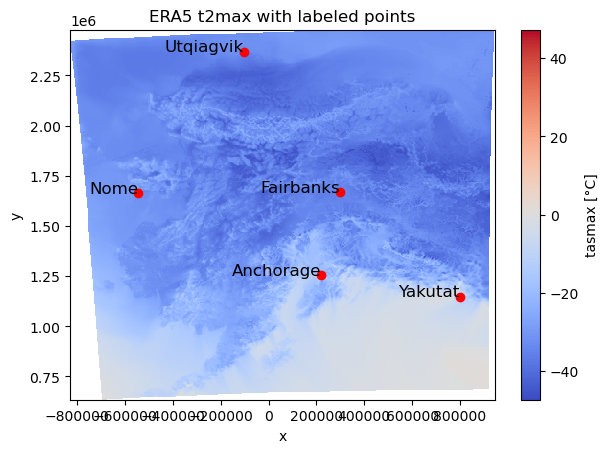

In [4]:
# Define the WKT projection for the ERA5 data
wkt_projection = era5_ds.spatial_ref.attrs["crs_wkt"]

proj = Proj(wkt_projection)

# Convert lat, lon to the projection system
projected_coords = {}
for point, latlon in baeda.coords.items():
    x, y = proj(latlon["lon"], latlon["lat"])
    projected_coords[point] = {"x": x, "y": y}

time_slice = era5_ds["tasmax"].isel(time=0).plot(cmap="coolwarm")

for point, coord in projected_coords.items():
    plt.plot(coord["x"], coord["y"], "ro")
    plt.text(coord["x"], coord["y"], point, fontsize=12, ha="right")

plt.tight_layout()
plt.title("ERA5 t2max with labeled points")
plt.xlabel("x")
plt.ylabel("y")
plt.show()

We will also choose some pixels based on the extremeness of the location in terms of the ERA5 data:
* the coldest and warmest pixels (min and max of tasmax over timeseries)
* the average coldest and warmest (min and max of the mean of the timeseries)
* the driest and wettest, and average driest/wettest pixels, same as for the temperature extremes

In [5]:
extreme_pixels = {}
extreme_pixels["warmest"] = {}

In [6]:
def get_coords(da, extr_da):
    return {
        coord: da.where(da == extr_da, drop=True).squeeze()[coord].item()
        for coord in ["x", "y"]
    }


tasmax_da = era5_ds["tasmax"]
tmax_da = tasmax_da.max(dim="time").load()
extreme_pixels["warmest"] = get_coords(tmax_da, tmax_da.max())
tmin_da = tasmax_da.min(dim="time").load()
extreme_pixels["coldest"] = get_coords(tmin_da, tmin_da.min())
tmean_da = tasmax_da.mean(dim="time").load()
extreme_pixels["avg_warmest"] = get_coords(tmean_da, tmean_da.max())
extreme_pixels["avg_coldest"] = get_coords(tmean_da, tmean_da.min())

prtot = era5_ds["pr"].sum(dim="time", skipna=False).load()
prtot = prtot.where(prtot != 0)
extreme_pixels["wettest"] = get_coords(prtot, prtot.max())
extreme_pixels["driest"] = get_coords(prtot, prtot.min())
prmean = era5_ds["pr"].mean(dim="time").load()
prmean = prmean.where(prmean != 0)
extreme_pixels["avg_wettest"] = get_coords(prmean, prmean.max())
extreme_pixels["avg_driest"] = get_coords(prmean, prmean.min())

/home/kmredilla/miniconda3/envs/cmip6-utils/lib/python3.12/site-packages/dask/array/reductions.py:655: RuntimeWarning: All-NaN slice encountered
  return np.nanmax(x_chunk, axis=axis, keepdims=keepdims)


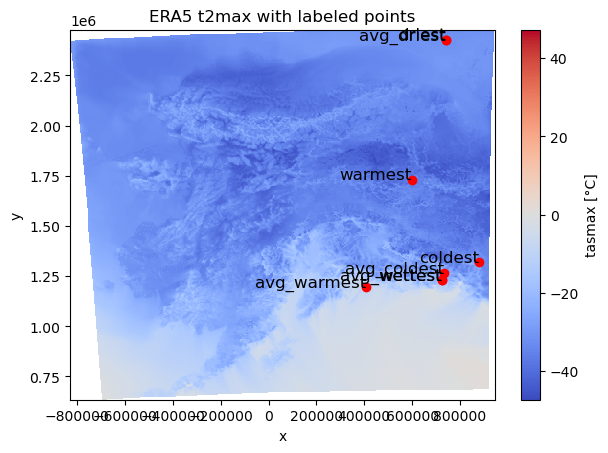

In [7]:
time_slice = era5_ds["tasmax"].isel(time=0).plot(cmap="coolwarm")

for point, coord in extreme_pixels.items():
    plt.plot(coord["x"], coord["y"], "ro")
    plt.text(coord["x"], coord["y"], point, fontsize=12, ha="right")

plt.tight_layout()
plt.title("ERA5 t2max with labeled points")
plt.xlabel("x")
plt.ylabel("y")
plt.show()

Looks like the wettest / avg wettest and driest / avg driest are the same, so we will just drop the avg_ versions of each, and instead choose two other locations in areas not yet represented: SW AK and the Brooks range. 
* SW of McGrath: 62.34197473303873, -157.0680089353049
* N of Arctic Village: 68.8372974190039, -145.63669025232795

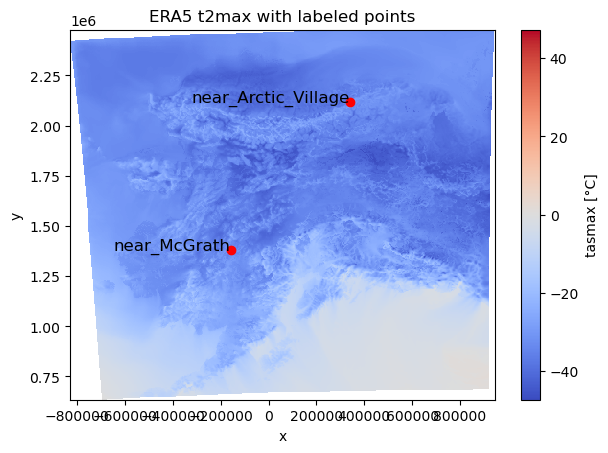

In [8]:
# drop avg_wettest and avg_driest
del extreme_pixels["avg_wettest"]
del extreme_pixels["avg_driest"]

# convert these other coordinates
other_coords = {
    "near_McGrath": {"lat": 62.34197473303873, "lon": -157.0680089353049},
    "near_Arctic_Village": {"lat": 68.8372974190039, "lon": -145.63669025232795},
}
for point, latlon in other_coords.items():
    x, y = proj(latlon["lon"], latlon["lat"])
    other_coords[point] = {"x": x, "y": y}

time_slice = era5_ds["tasmax"].isel(time=0).plot(cmap="coolwarm")

for point, coord in other_coords.items():
    plt.plot(coord["x"], coord["y"], "ro")
    plt.text(coord["x"], coord["y"], point, fontsize=12, ha="right")

plt.tight_layout()
plt.title("ERA5 t2max with labeled points")
plt.xlabel("x")
plt.ylabel("y")
plt.show()

Extract the ERA5 data for all of the test locations:

In [9]:
# combine all coordinates together
coords = {
    point: {"x": coord["x"], "y": coord["y"]} for point, coord in extreme_pixels.items()
}
for point, coord in projected_coords.items():
    coords[point] = {"x": coord["x"], "y": coord["y"]}
for point, coord in other_coords.items():
    coords[point] = {"x": coord["x"], "y": coord["y"]}

era5_extr = baeda.extract_era5_time_series(
    era5_ds, coords
).load()  # loading to help keep future graph sizes down

## Methods

### Extraction and adjustment

We will extract and perform bias adjustment for the test locations and for each of the DQM and QDM methods specified in the `baeda` module. 
The `baeda.run_bias_adjustment_and_package_data` does this and wraps the results up into a dataframe. 

### Summarization

Once we have the results, we can create some summaries to aid in evaluation of the methods. For each variable, we will compute a set of indicators (i.e. indices) across all datasets (including ERA5 and unadjusted GCM historical and future). These indicators will be used in the following ways:

1. To compare distributions between adjusted GCM historical and the ERA5 reference data
2. To evaluate the ability of methods to preserve the changes in these indicators

## Historical GCM fidelity to ERA5 reference

Here we will compare adjusted historical GCM data with the ERA5.

First, compute the historical indicators for packaging with GCM results:

In [105]:
for var_id in var_ids:
    era5_indicators = baeda.run_indicators(
        era5_extr[var_id].assign_coords(Method="ERA5").expand_dims(["Method"]),
        era5_extr[var_id],
    )
    # save the era5 indicators
    results["ERA5"][var_id]["indicators"] = era5_indicators


### Maximum daily temperature (`tasmax`)

Perform bias adjustment and do some data wrangling / packaging:

In [187]:
# given some issues with calling dask .load and similar from within a module,
# we will be extracting / loading the data prior to passing to module functions.
# not sure why this is. And it's not totally consistent. But it does seem to happen.
#

model = "GFDL-ESM4"
scenario = "ssp245"
var_id = "tasmax"


hist_extr, sim_extr = baeda.extract_time_series_from_zarr(
    zarr_dir, model, scenario, var_id, coords
)
_ = hist_extr.load(), sim_extr.load()
results = baeda.run_full_adjustment_and_summarize(
    hist_extr, sim_extr, era5_extr[var_id], results
)

Historical boxplots

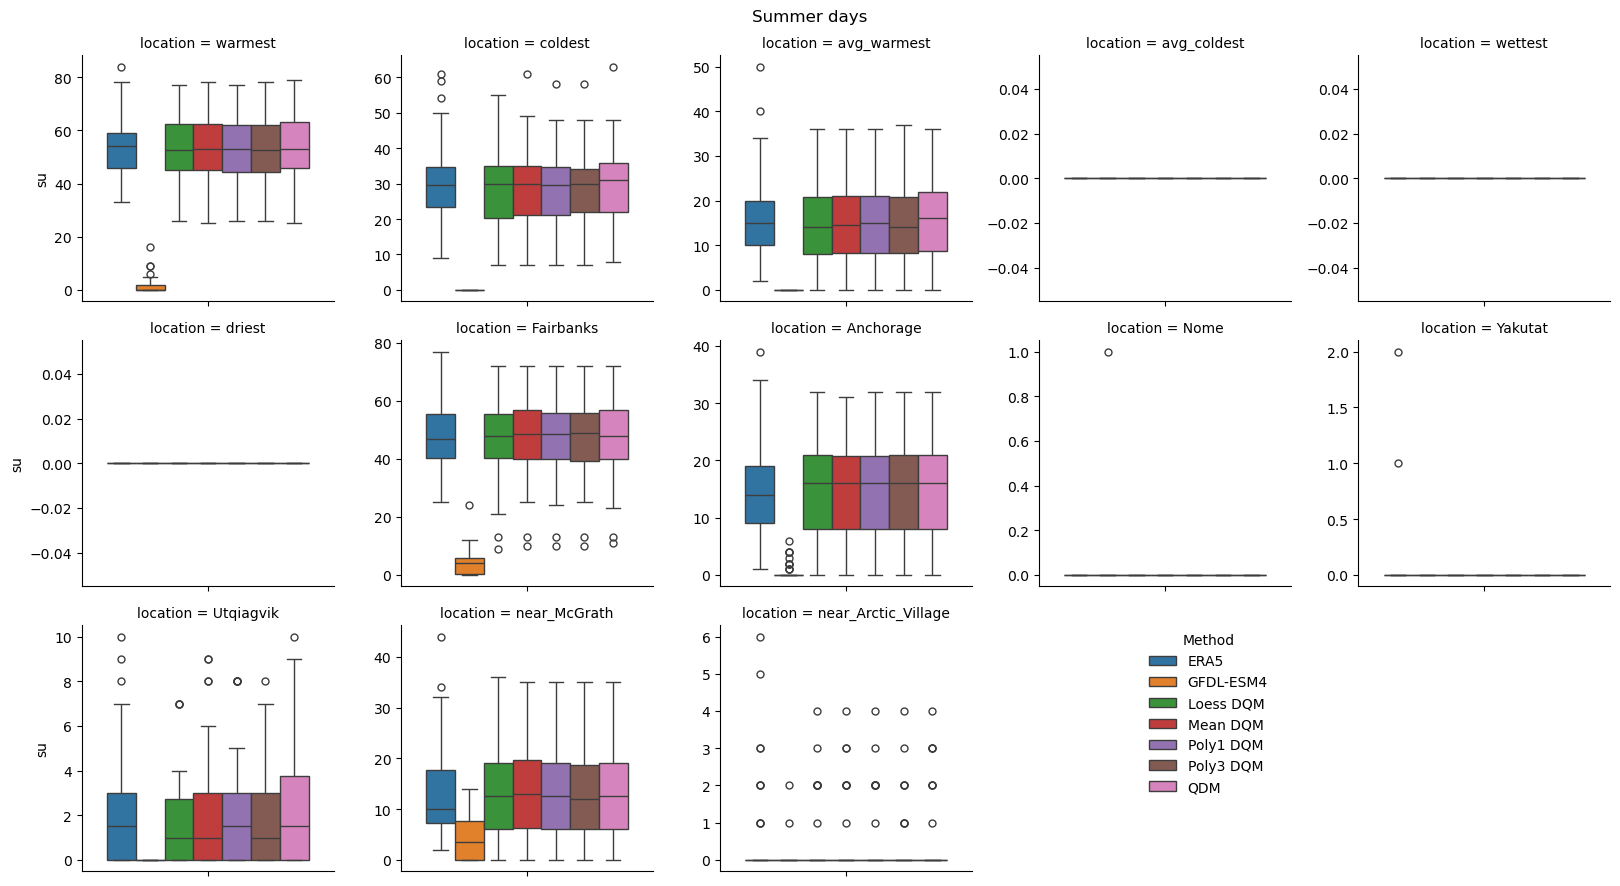

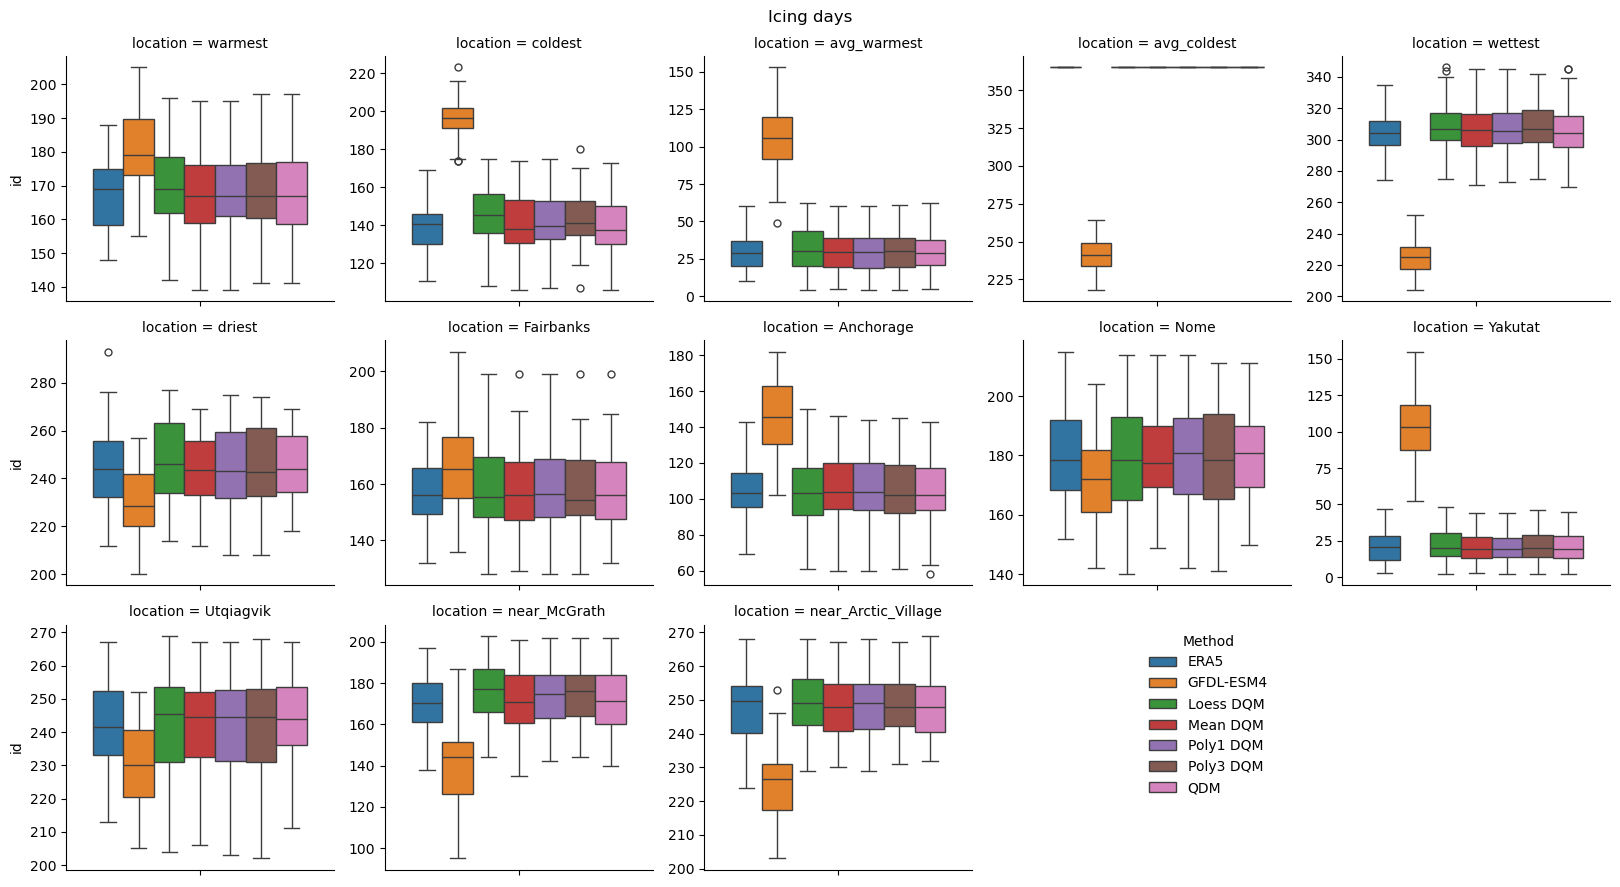

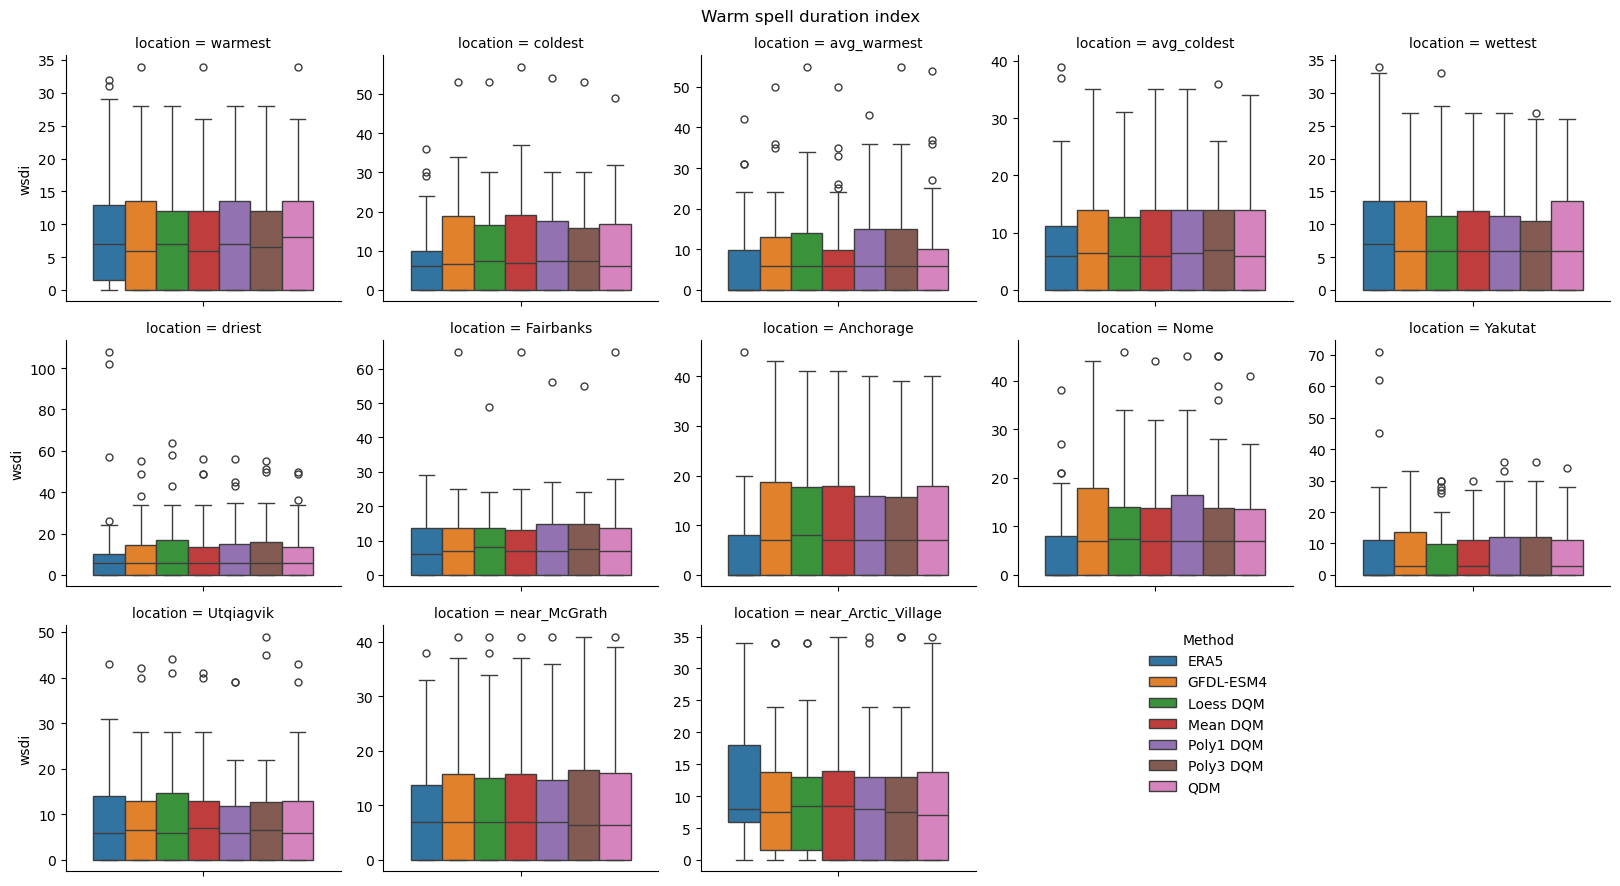

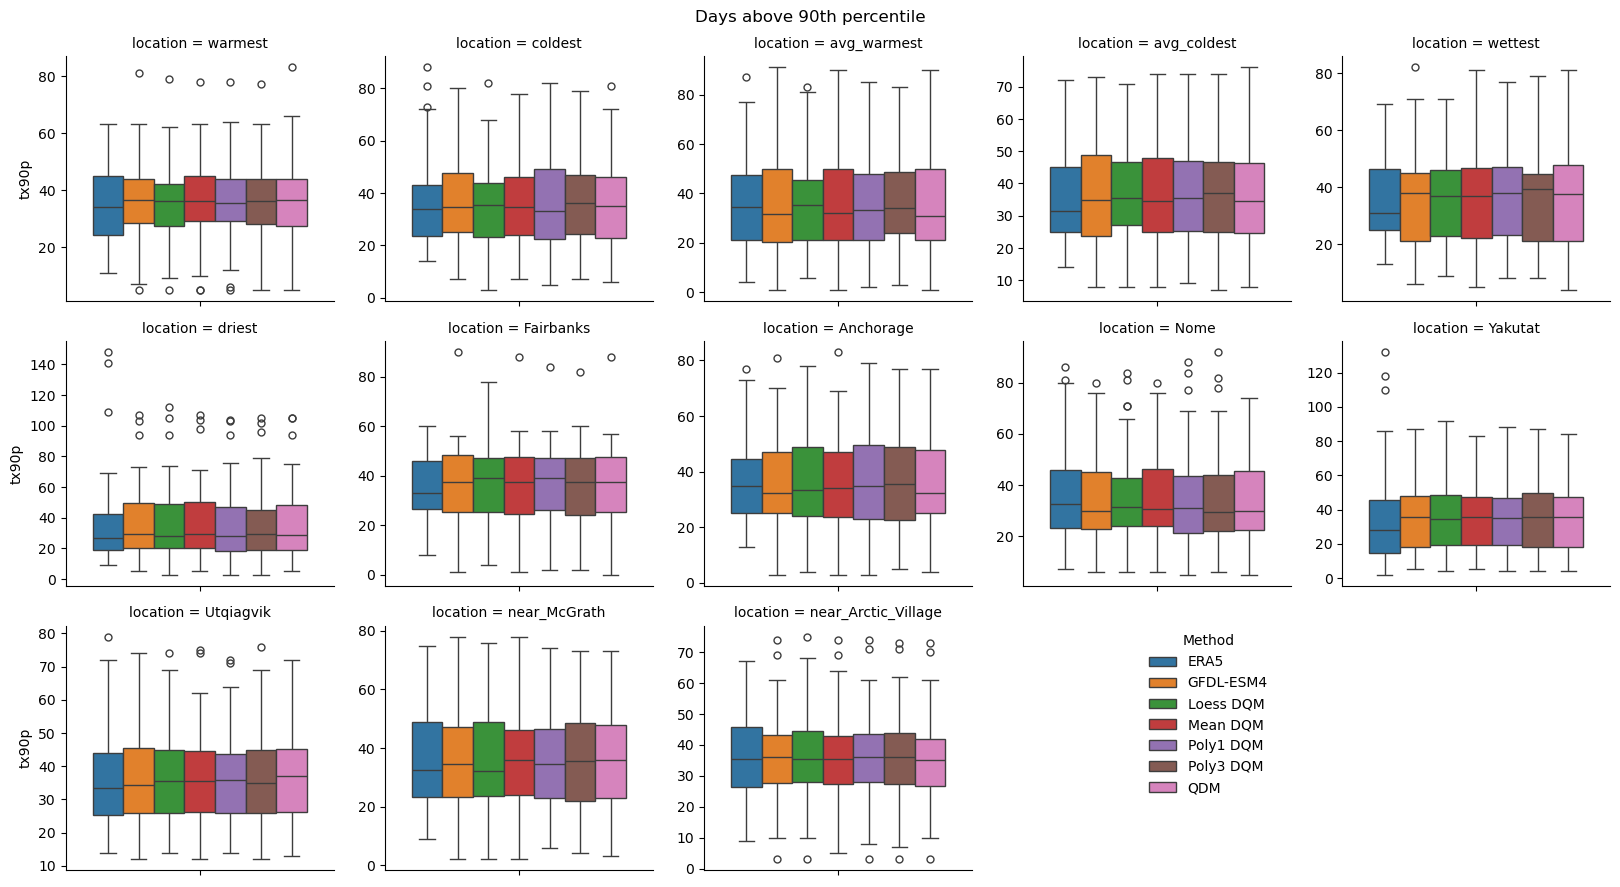

In [159]:
indicator_ds = results[model][var_id]["indicators"]["historical"]
for indicator in indicator_ds.data_vars:
    baeda.indicator_boxplot_by_method_location(indicator_ds, indicator)

### Daily precipitation (`pr`)

In [188]:
model = "GFDL-ESM4"
scenario = "ssp245"
var_id = "pr"


hist_extr, sim_extr = baeda.extract_time_series_from_zarr(
    zarr_dir, model, scenario, var_id, coords
)
_ = hist_extr.load(), sim_extr.load()
results = baeda.run_full_adjustment_and_summarize(
    hist_extr, sim_extr, era5_extr[var_id], results
)

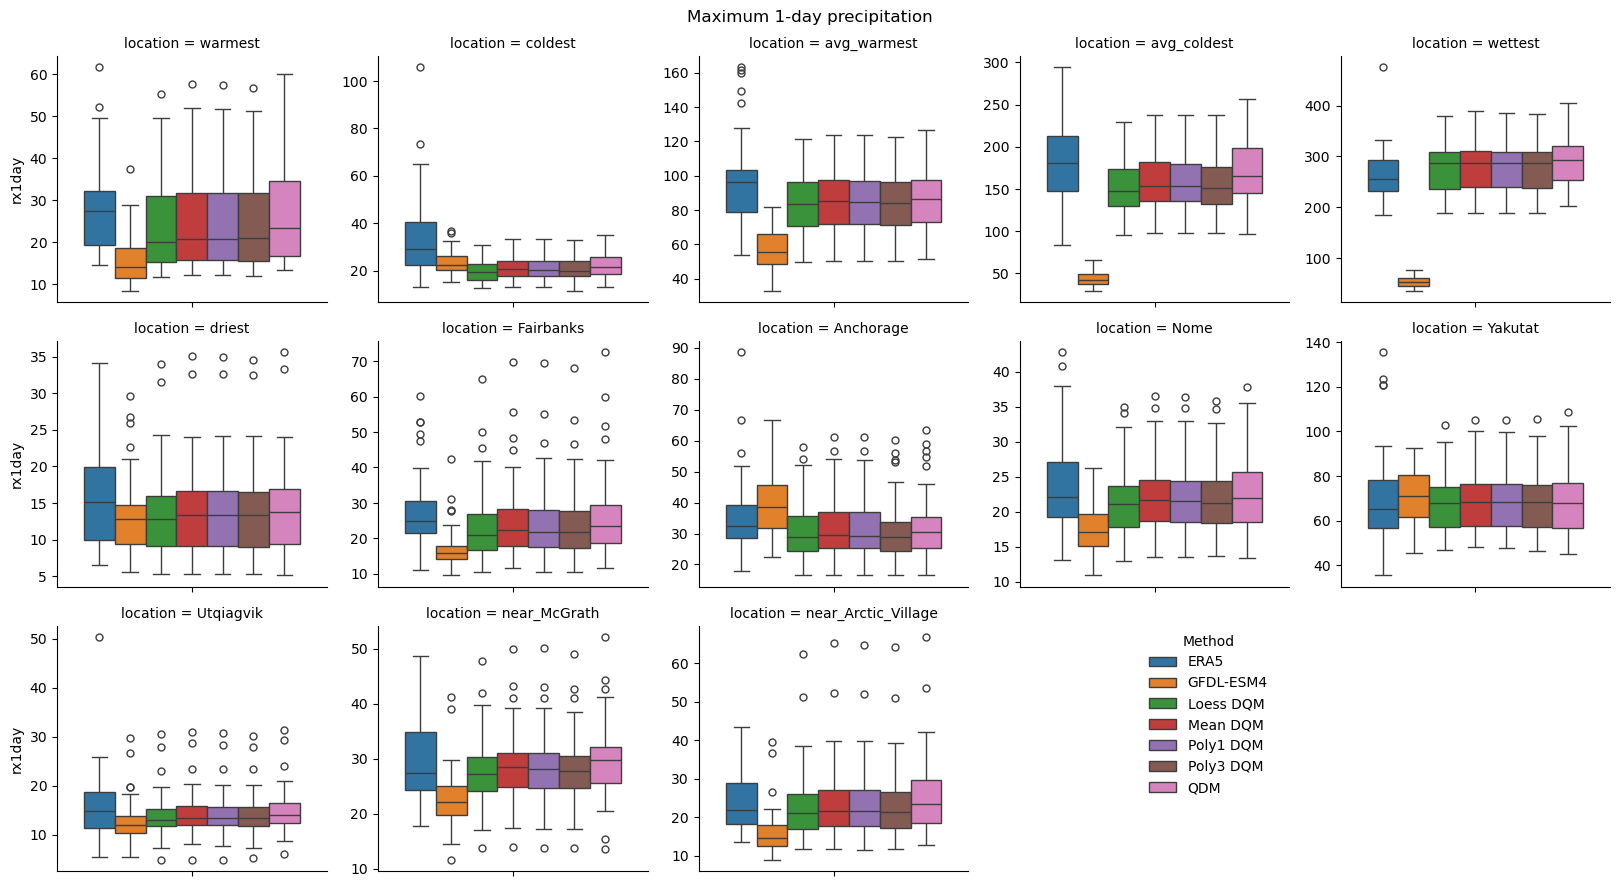

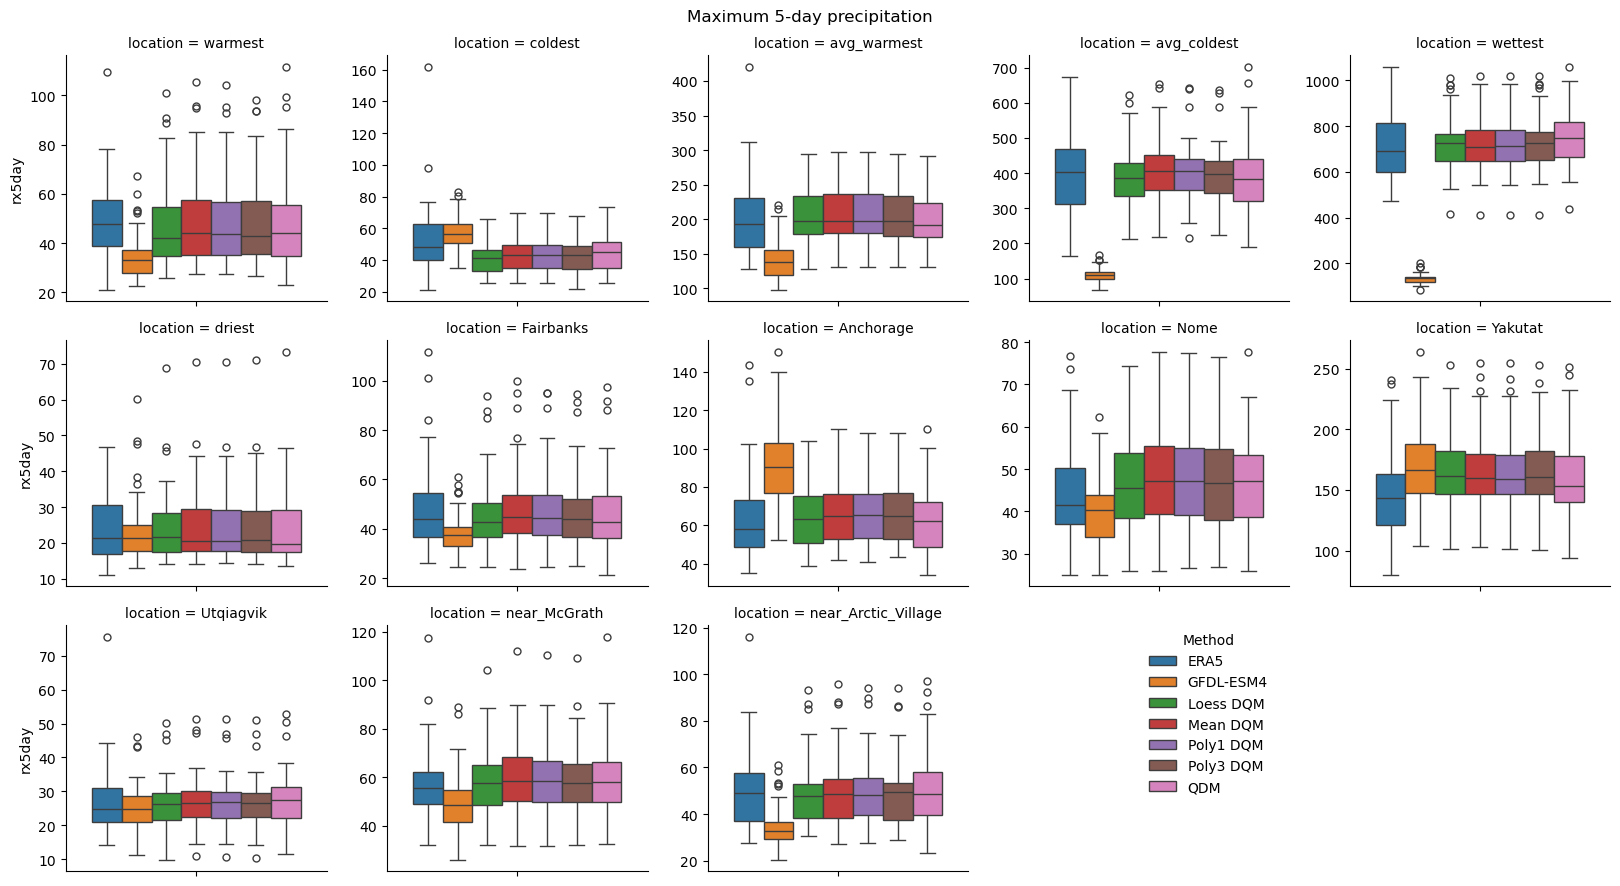

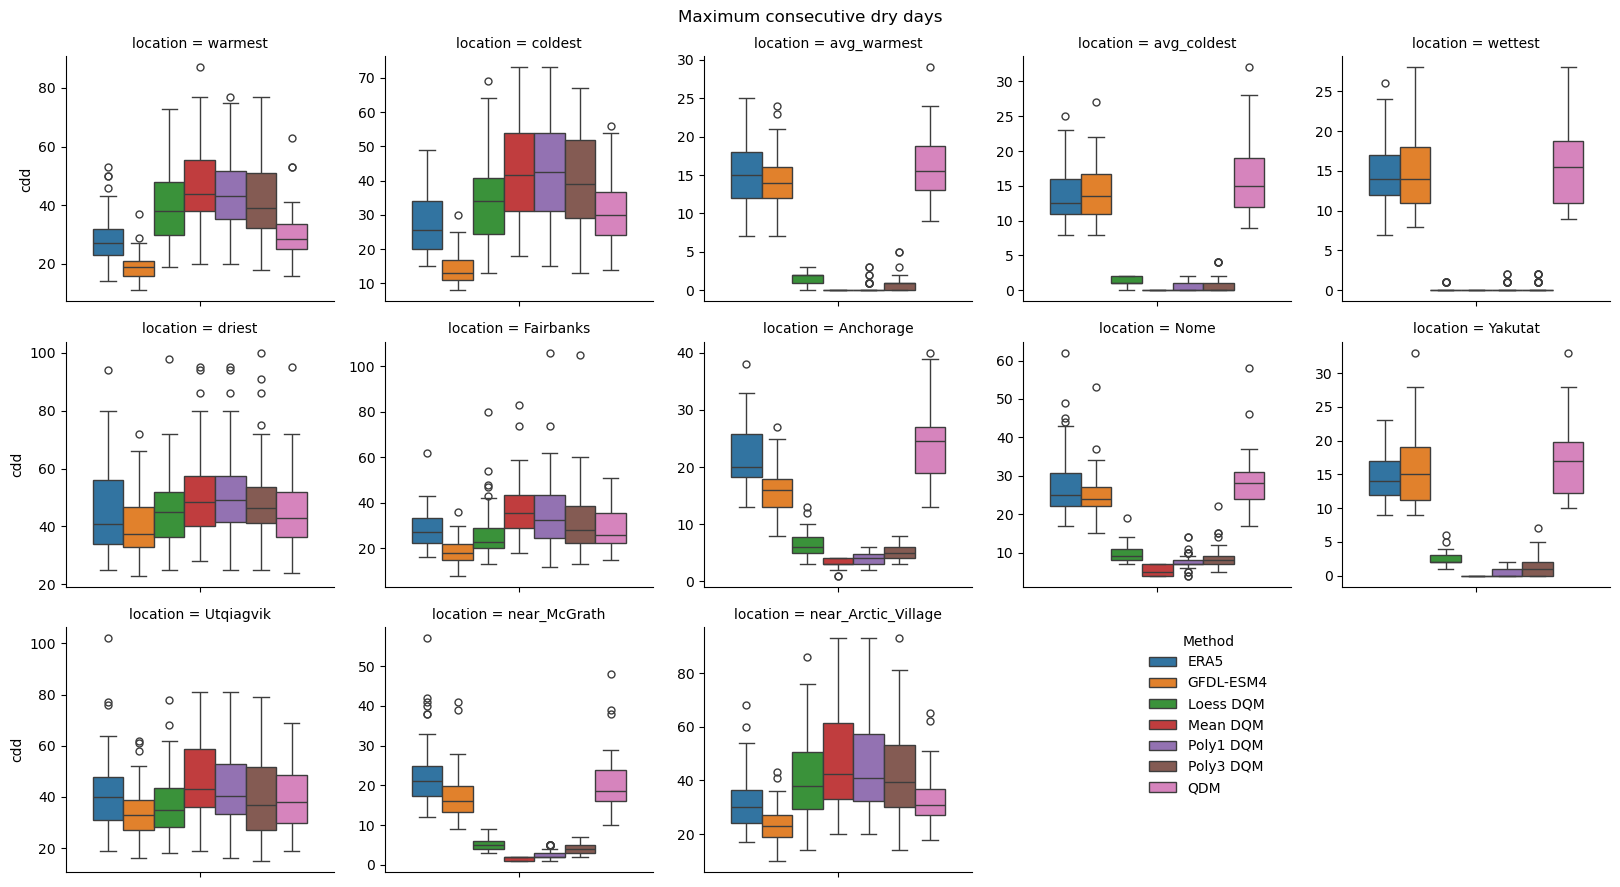

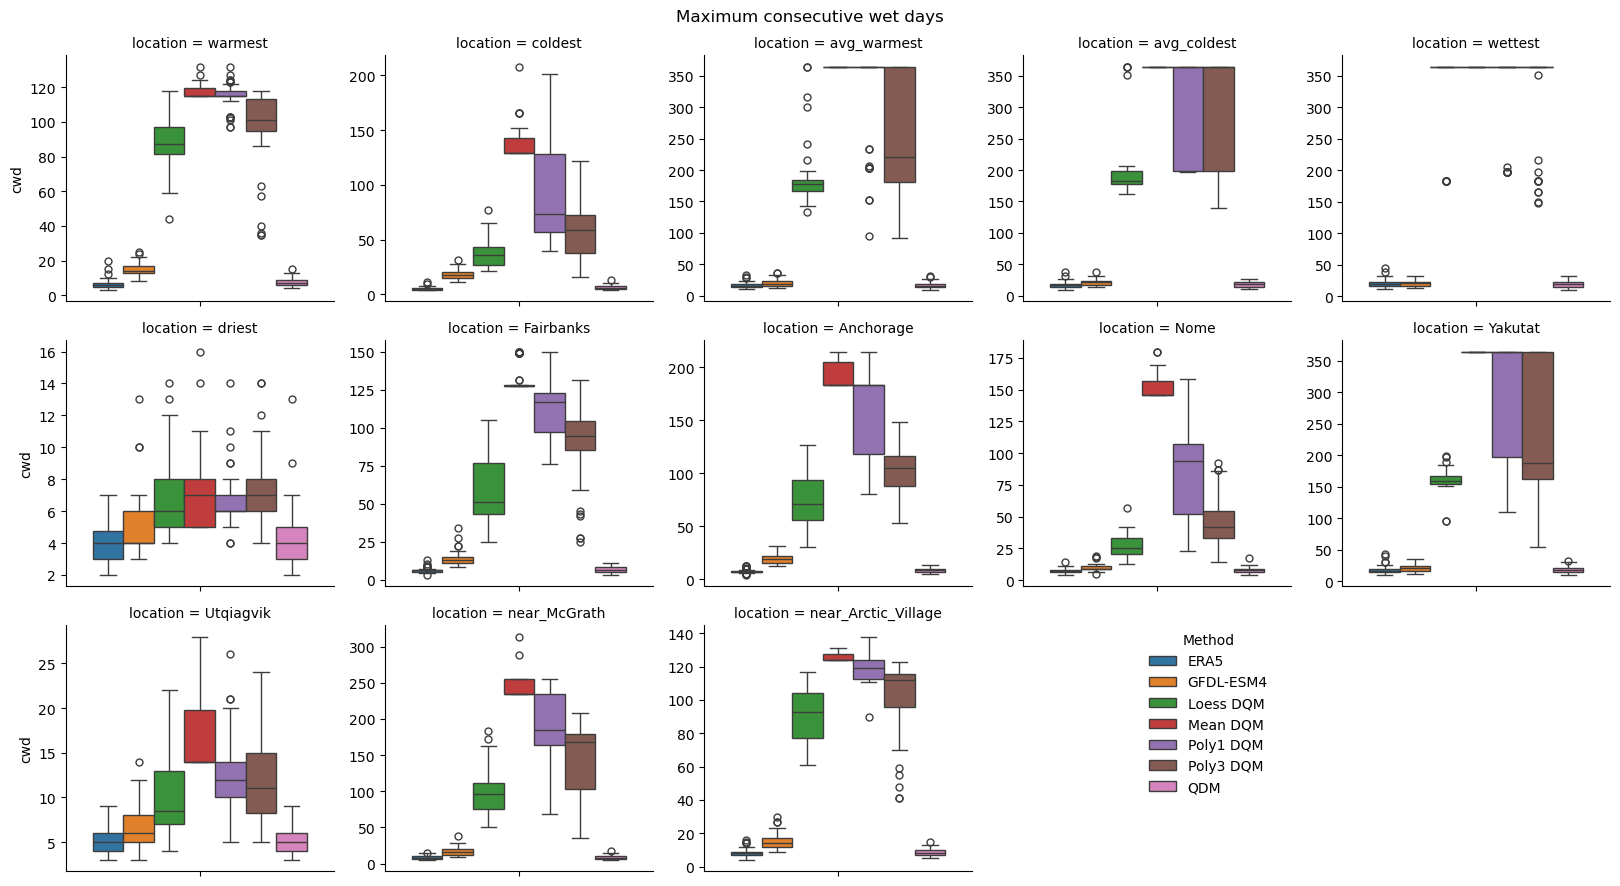

In [172]:
indicator_ds = results[model][var_id]["indicators"]["historical"]
for indicator in indicator_ds.data_vars:
    baeda.indicator_boxplot_by_method_location(indicator_ds, indicator)

## Preservation of projected change

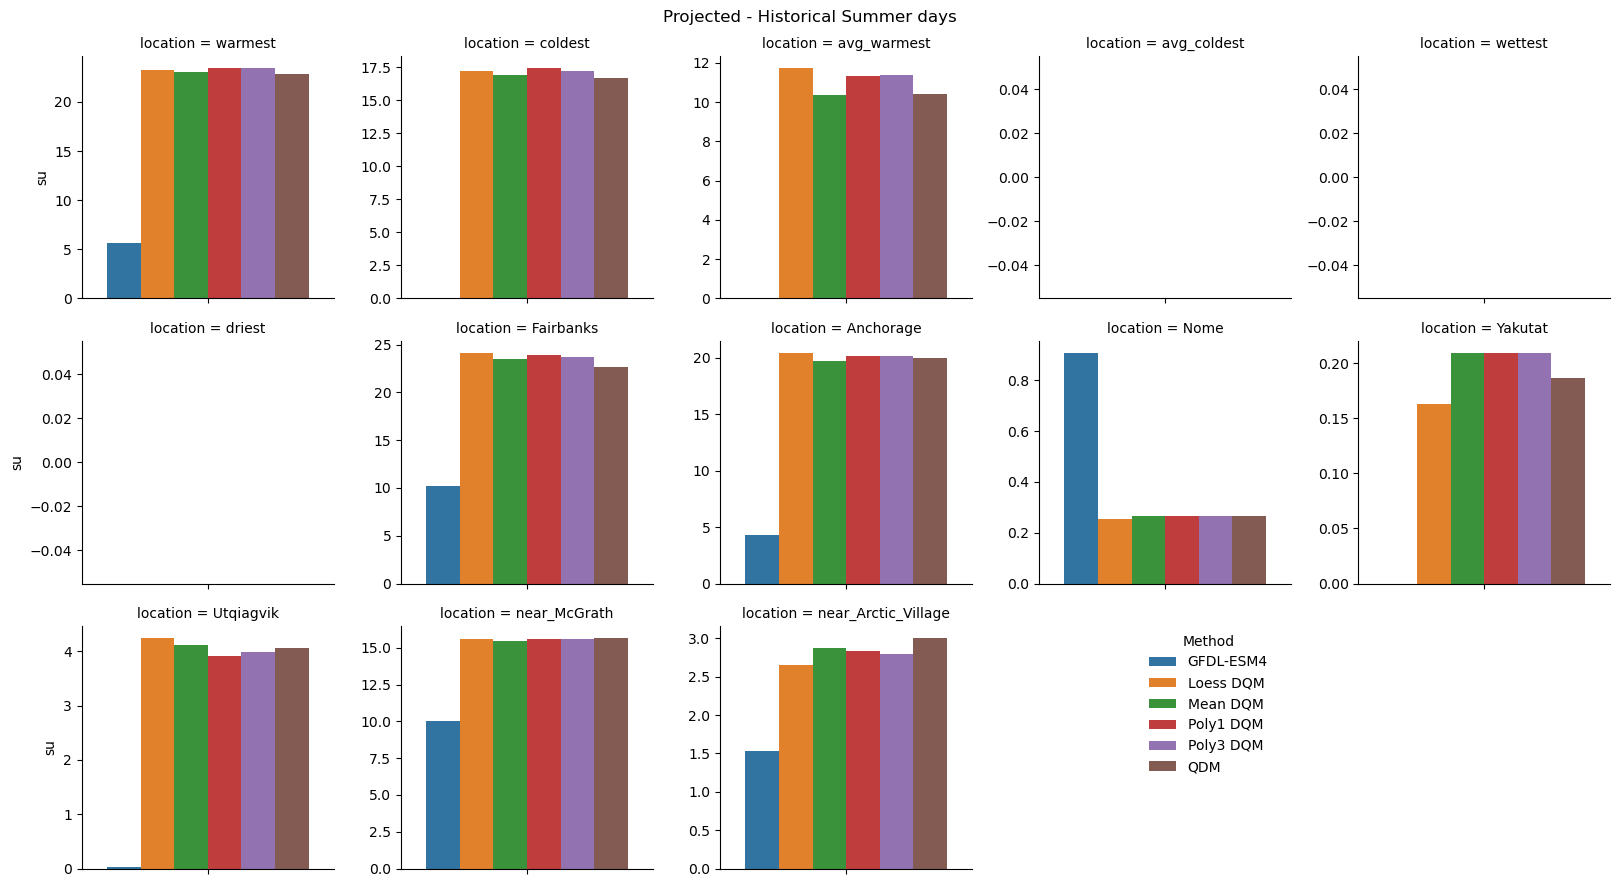

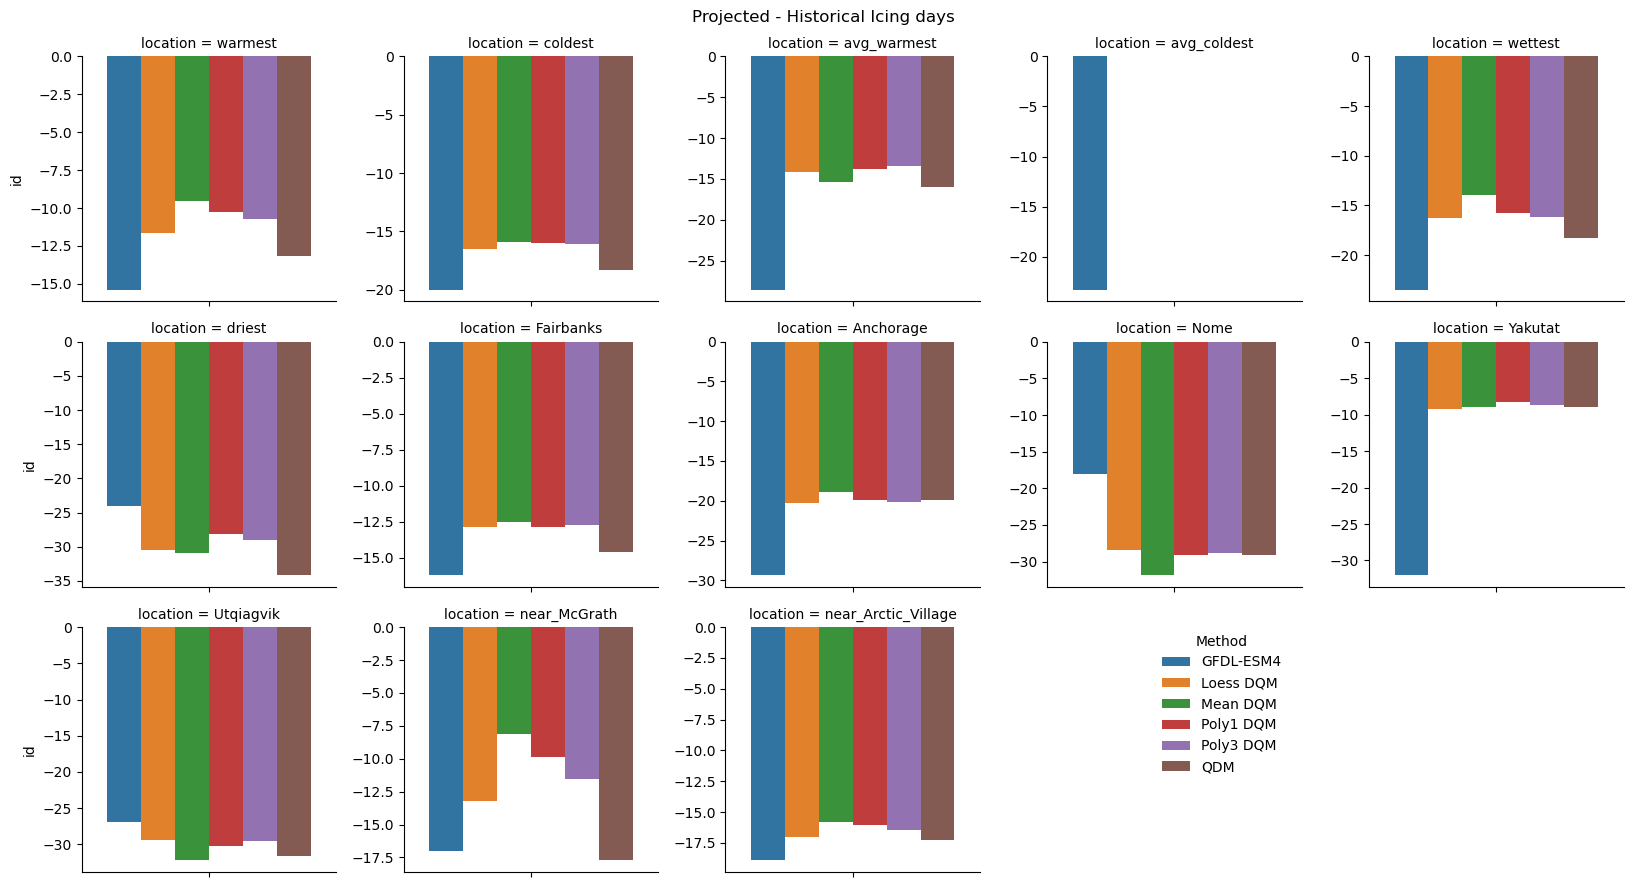

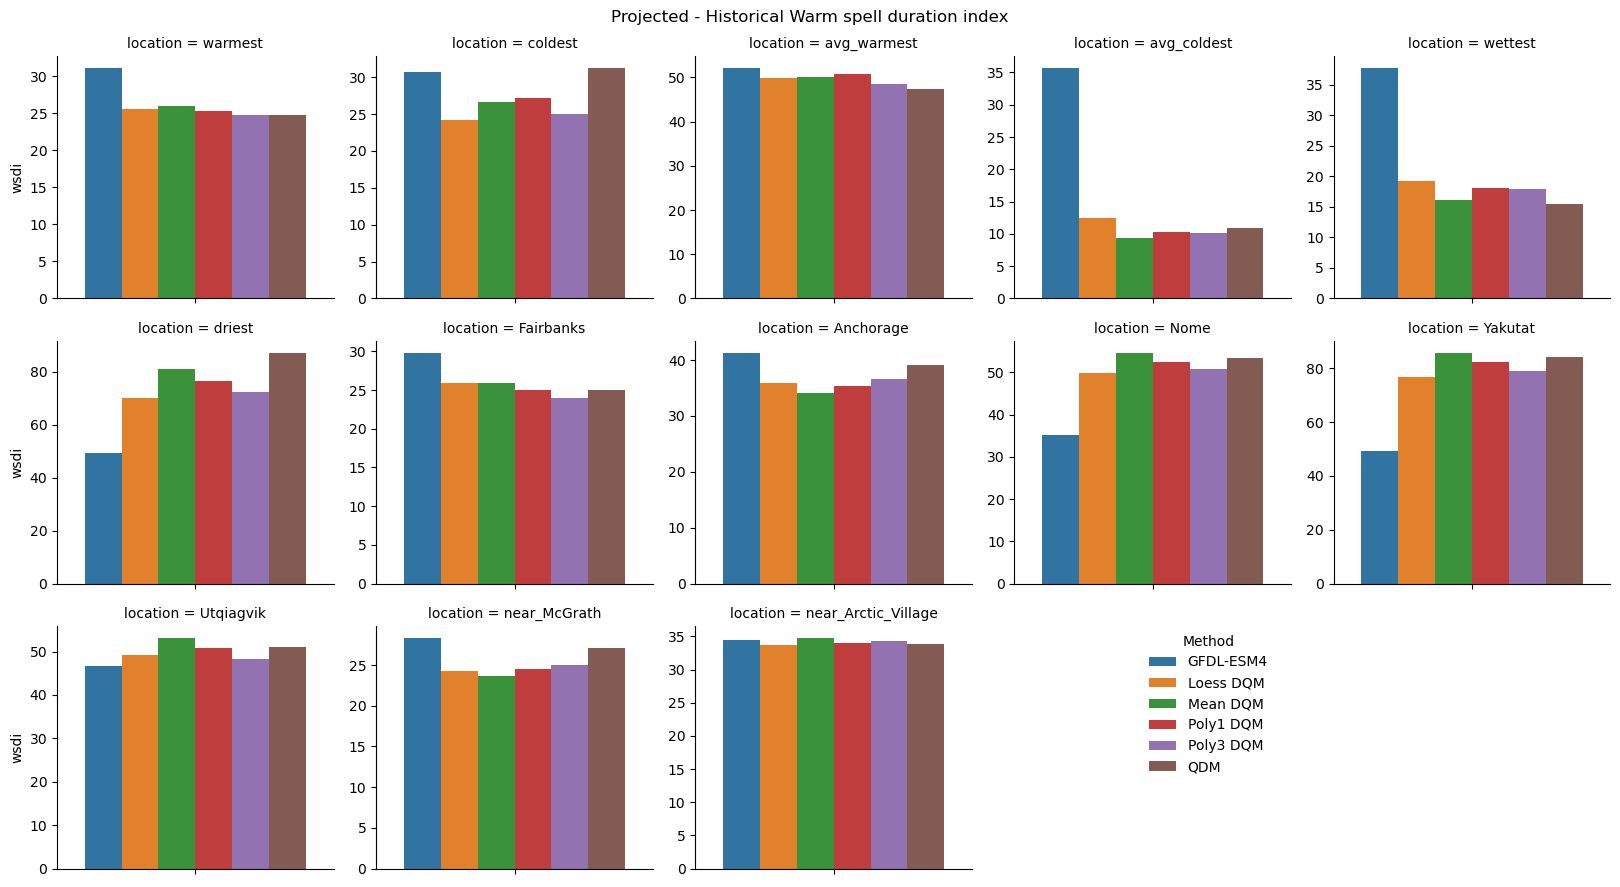

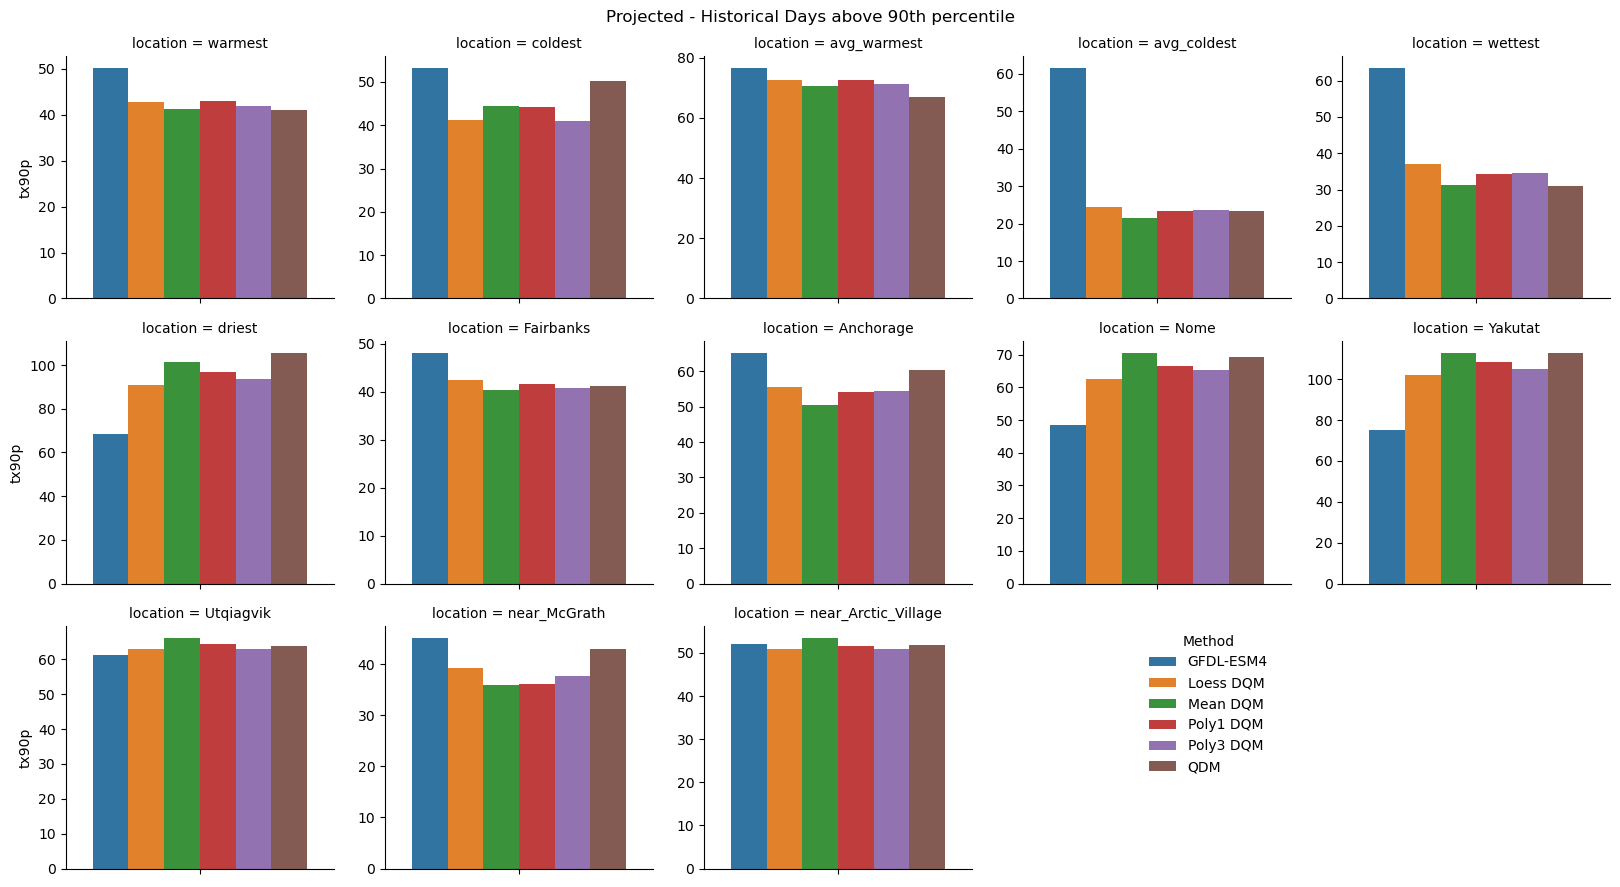

In [189]:
var_id = "tasmax"

hist_indicators = results[model][var_id]["indicators"]["historical"]
proj_indicators = results[model][var_id]["indicators"][scenario]

for indicator in hist_indicators.data_vars:
    baeda.indicator_deltas_by_method_location(
        proj_indicators, hist_indicators, indicator
    )

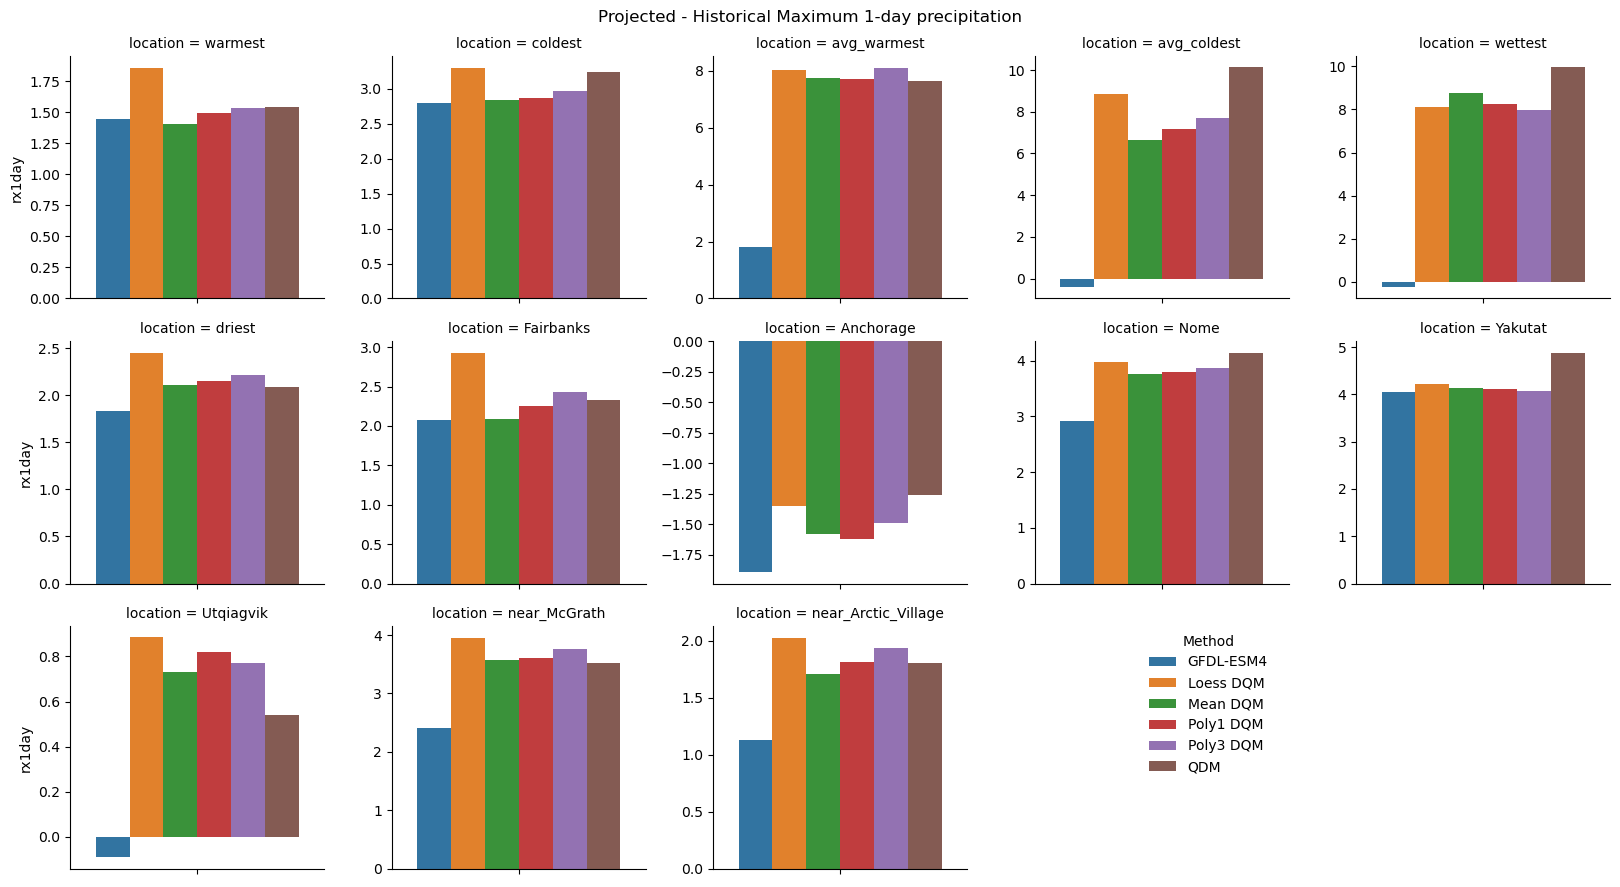

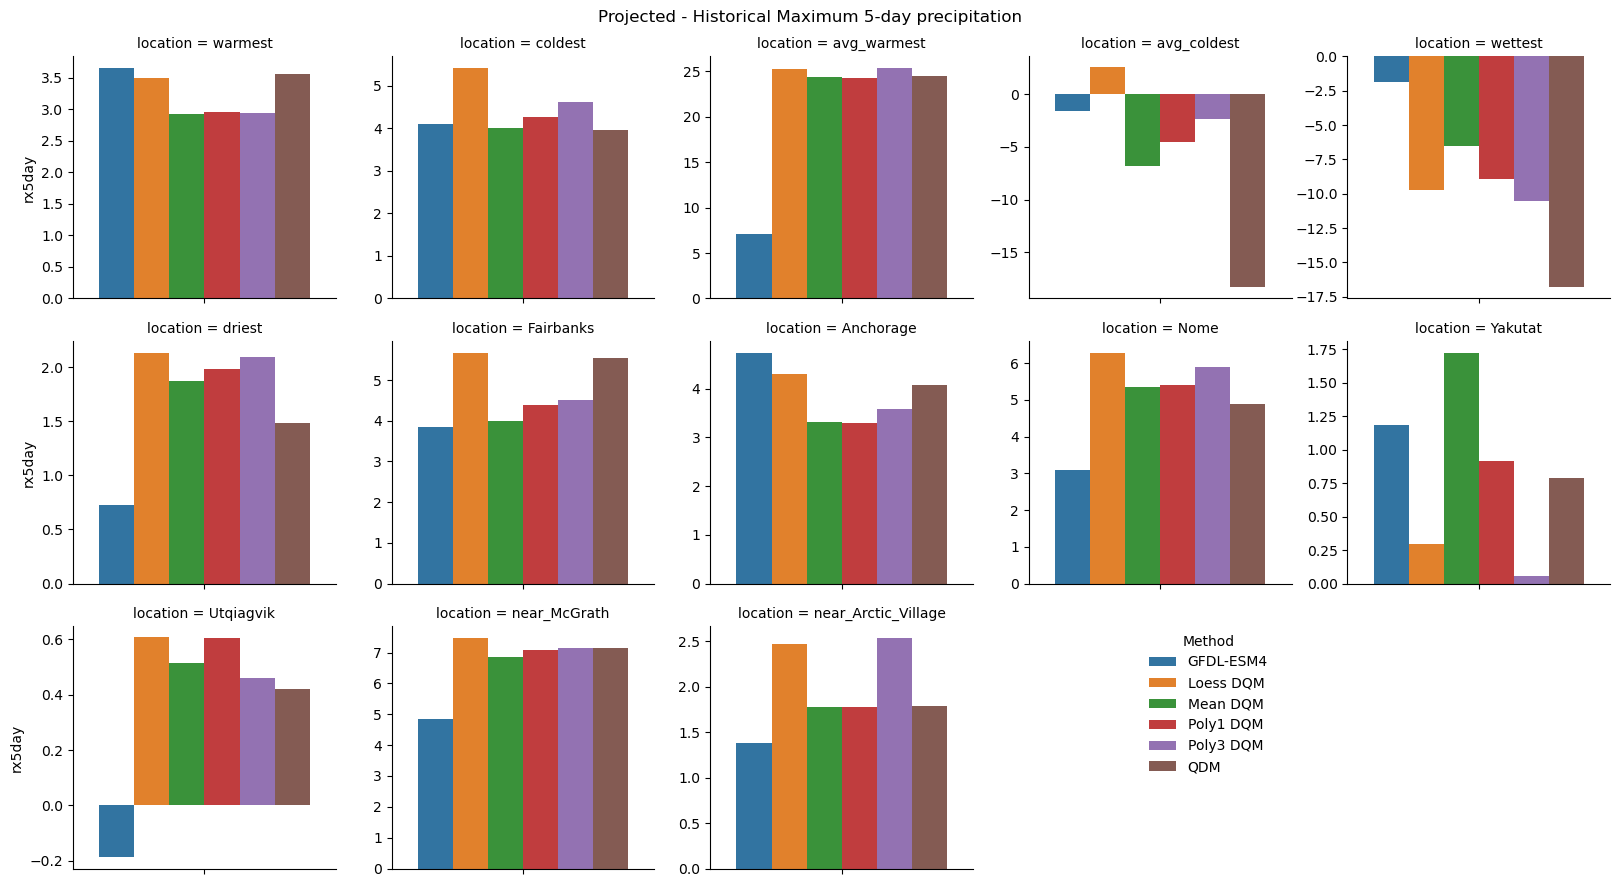

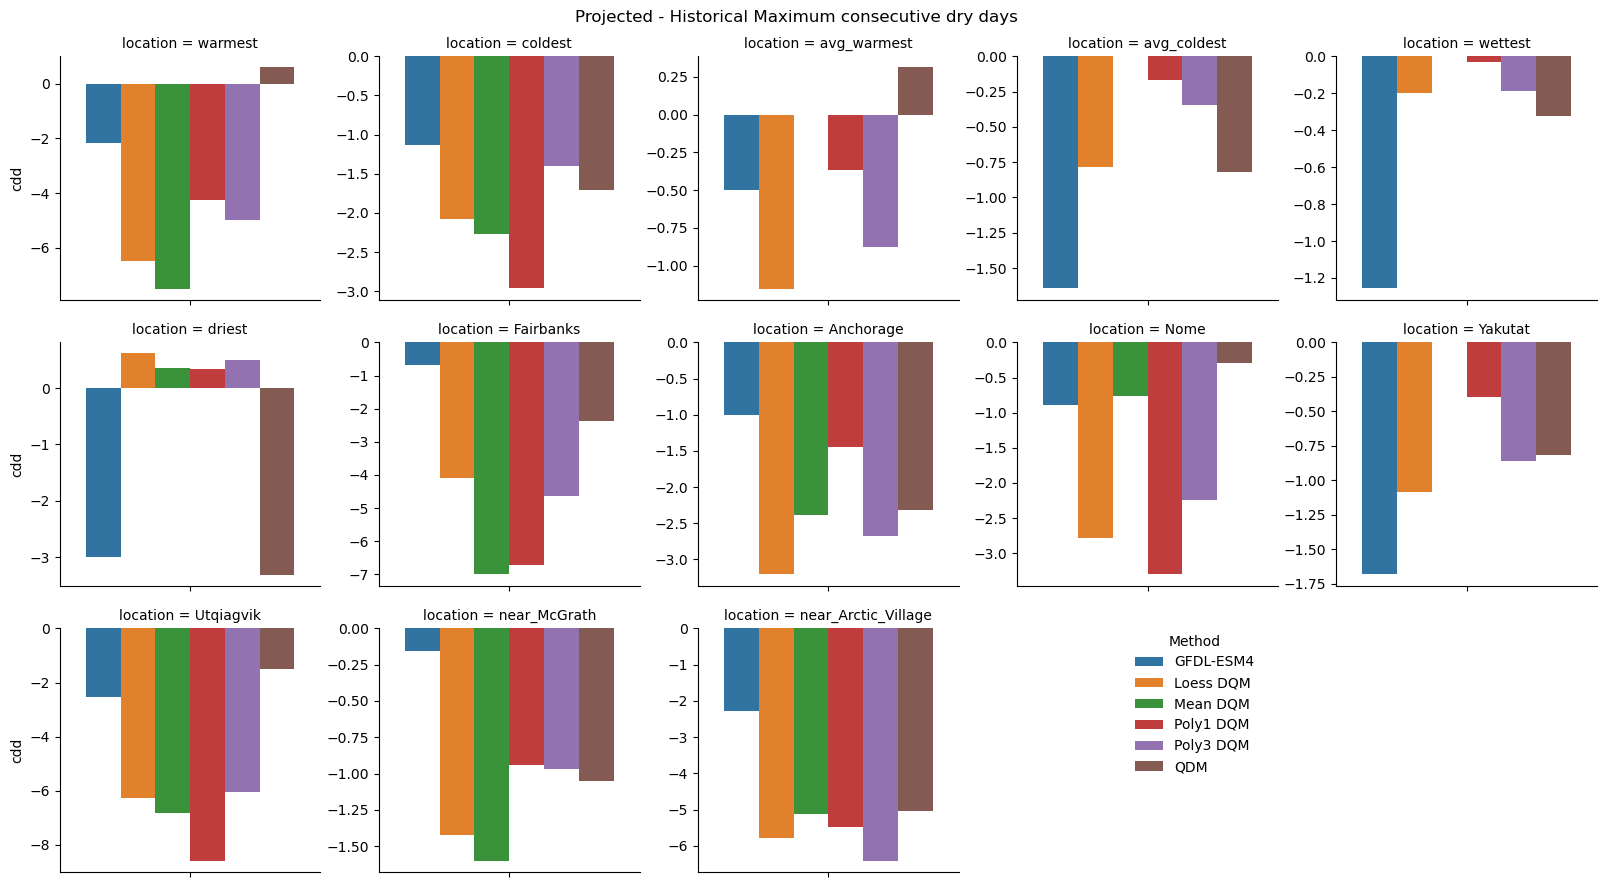

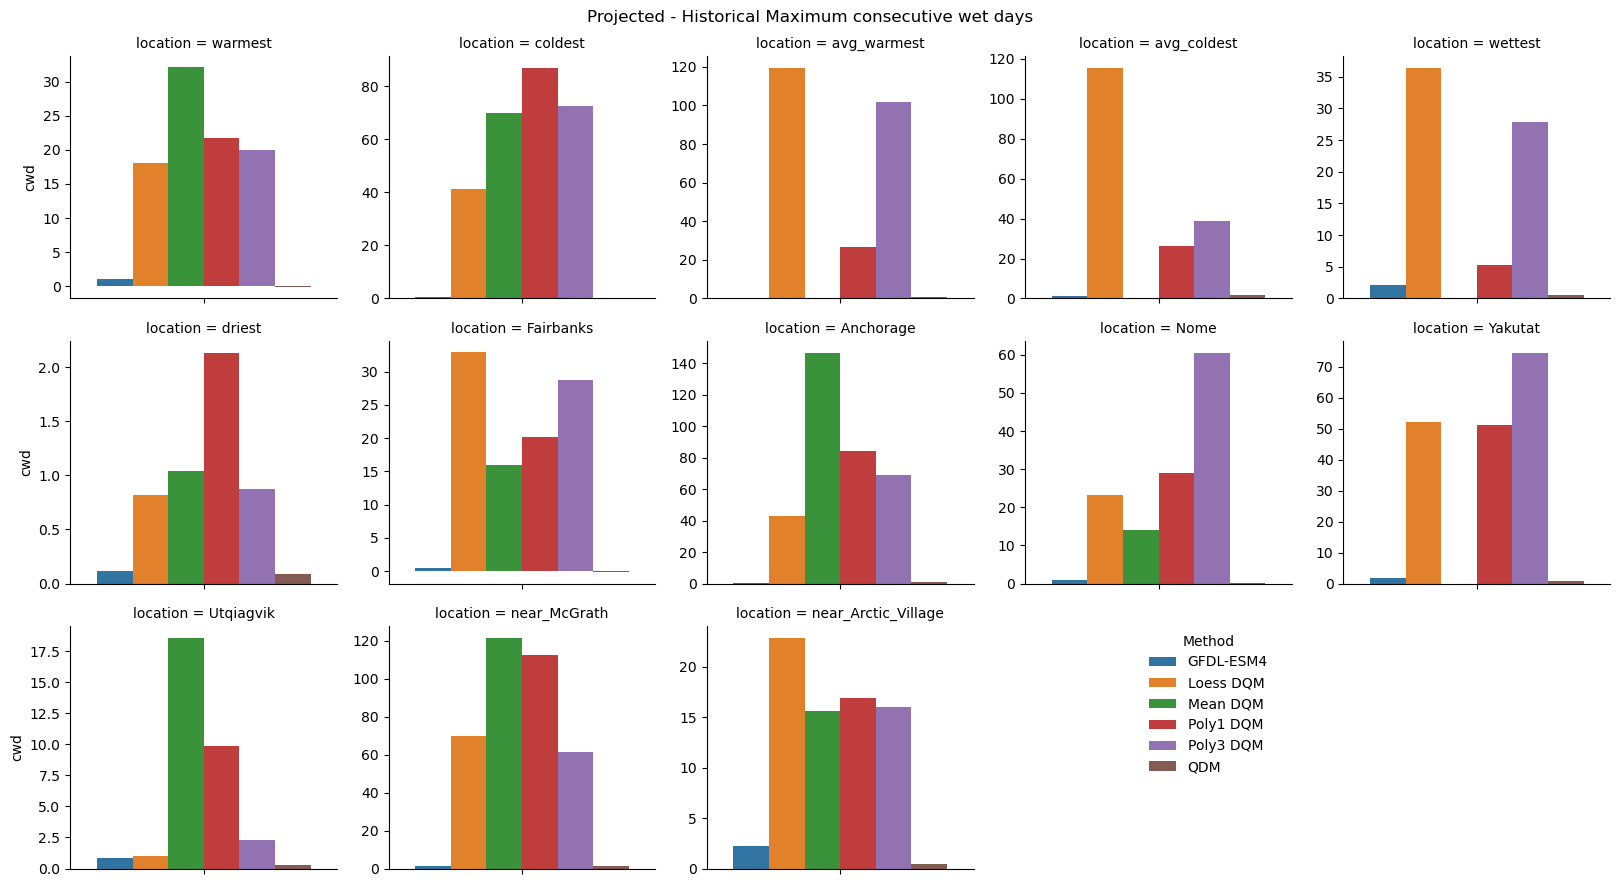

In [190]:
var_id = "pr"

hist_indicators = results[model][var_id]["indicators"]["historical"]
proj_indicators = results[model][var_id]["indicators"][scenario]

for indicator in hist_indicators.data_vars:
    baeda.indicator_deltas_by_method_location(
        proj_indicators, hist_indicators, indicator
    )